In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap

cm_cycle = ListedColormap(['#0000aa', '#ff5050', '#50ff50', '#9040a0', '#fff000'])
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])

# create a smooth transition from the first to to the second color of cm3
# similar to RdBu but with our red and blue, also not going through white,
# which is really bad for greyscale

cdict = {'red': [(0.0, 0.0, cm2(0)[0]),
                 (1.0, cm2(1)[0], 1.0)],

         'green': [(0.0, 0.0, cm2(0)[1]),
                   (1.0, cm2(1)[1], 1.0)],

         'blue': [(0.0, 0.0, cm2(0)[2]),
                  (1.0, cm2(1)[2], 1.0)]}

ReBl = LinearSegmentedColormap("ReBl", cdict)
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
    Parameters
    ----------
    x1 : nd-array
        input data, first axis
    x2 : nd-array
        input data, second axis
    y : nd-array
        input data, discrete labels
    cmap : colormap
        Colormap to use.
    markers : list of string
        List of markers to use, or None (which defaults to 'o').
    s : int or float
        Size of the marker
    padding : float
        Fraction of the dataset range to use for padding the axes.
    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

#############

import numpy as np
import matplotlib.pyplot as plt
def plot_2d_classification(classifier, X, fill=False, ax=None, eps=None,
                           alpha=1, cm=cm3):
    # multiclass
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    decision_values = classifier.predict(X_grid)
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max,
                                                         y_min, y_max),
              aspect='auto', origin='lower', alpha=alpha, cmap=cm)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

##############

def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,
                      cm=cm2, linewidth=None, threshold=None,
                      linestyle="solid"):
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    if hasattr(classifier, "decision_function"):
        decision_values = _call_classifier_chunked(classifier.decision_function,
                                                   X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [
            decision_values.max()]
    else:
        # no decision_function
        decision_values = _call_classifier_chunked(classifier.predict_proba,
                                                   X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

def _call_classifier_chunked(classifier_pred_or_decide, X):
    # The chunk_size is used to chunk the large arrays to work with x86
    # memory models that are restricted to < 2 GB in memory allocation. The
    # chunk_size value used here is based on a measurement with the
    # MLPClassifier using the following parameters:
    # MLPClassifier(solver='lbfgs', random_state=0,
    #               hidden_layer_sizes=[1000,1000,1000])
    # by reducing the value it is possible to trade in time for memory.
    # It is possible to chunk the array as the calculations are independent of
    # each other.
    # Note: an intermittent version made a distinction between
    # 32- and 64 bit architectures avoiding the chunking. Testing revealed
    # that even on 64 bit architectures the chunking increases the
    # performance by a factor of 3-5, largely due to the avoidance of memory
    # swapping.
    chunk_size = 10000

    # We use a list to collect all result chunks
    Y_result_chunks = []

    # Call the classifier in chunks.
    for x_chunk in np.array_split(X, np.arange(chunk_size, X.shape[0],
                                               chunk_size, dtype=np.int32),
                                  axis=0):
        Y_result_chunks.append(classifier_pred_or_decide(x_chunk))

    return np.concatenate(Y_result_chunks)

#############
from scipy import ndimage
def plot_tree_partition(X, y, tree, ax=None):
    if ax is None:
        ax = plt.gca()
    eps = X.std() / 2.

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]

    Z = tree.predict(X_grid)
    Z = Z.reshape(X1.shape)
    faces = tree.apply(X_grid)
    faces = faces.reshape(X1.shape)
    border = ndimage.laplace(faces) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=1)

    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    return ax


# Decision trees
Plot the decision surface of a decision tree trained on pairs of features of the iris dataset.
For each pair of iris features, the decision tree learns decision boundaries made of combinations of simple thresholding rules inferred from the training samples.

See [decision tree](https://scikit-learn.org/stable/modules/tree.html#tree) for more information on the estimator.

We also show the tree structure of a model built on all of the features.
### Plot the decision surface of a decision tree on the iris dataset

(0.10000000000000009, 7.880000000000001, -0.9, 3.4800000000000044)

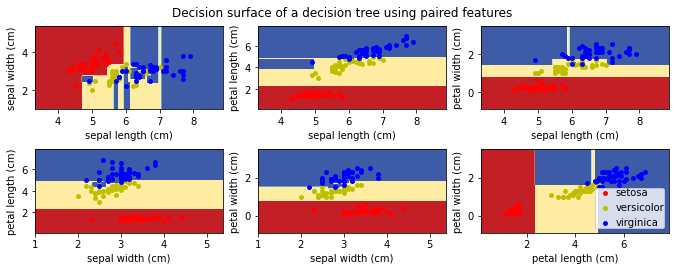

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier#, plot_tree
from sklearn import tree

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

# Load and prepare data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)


plt.figure(figsize=(10,4))
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = X_train[:, pair]
    y = y_train

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu,  s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")


### Visualizing the decision tree

#### For this section you need a version of sklearn that's greater than 0.21
To check if you have the correct version, run:

In [12]:
import sklearn
print(sklearn.__version__)
assert float(sklearn.__version__[2:]) >= 21, 'sklearn version insufficient.'

0.23.2


#### If an error shows, uncomment and then run the following line: 
Or open anaconda command prompt as administrator, and run:
pip install -U scikit-learn

In [13]:
#!pip install -U scikit-learn
print(sklearn.__version__)

0.23.2


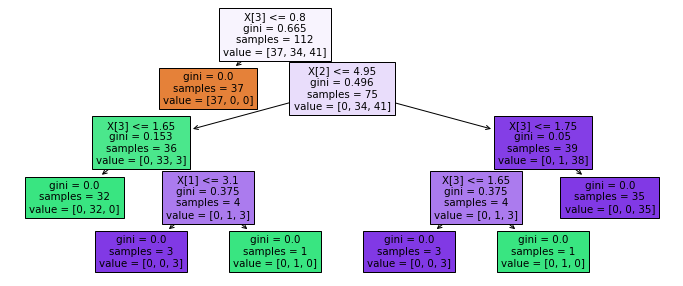

Accuracy on training set: 1.000
Accuracy on test set: 0.974


In [14]:
plt.figure(figsize=(12,5))
clf = DecisionTreeClassifier(max_depth=4, random_state=0).fit(X_train, y_train)
tree.plot_tree(clf, filled=True)
plt.show()

print("Accuracy on training set: {:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(clf.score(X_test, y_test)))

#### Try varying the depth and see the impact:

Text(0, 0.5, 'Accuracy')

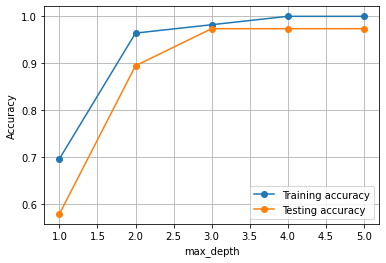

In [15]:
acc_train = []
acc_test = []
for depth in range(1,6):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0).fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
plt.figure()
x_axis = range(1, len(acc_train) + 1)
plt.plot(x_axis,acc_train,'o-', label='Training accuracy')
plt.plot(x_axis,acc_test,'o-', label='Testing accuracy')
plt.grid()
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

### Analyzing Decision Trees

#### Feature Importance in trees

In [16]:
print("Feature importances:")
print(clf.feature_importances_)

Feature importances:
[0.         0.02014872 0.39927524 0.58057605]


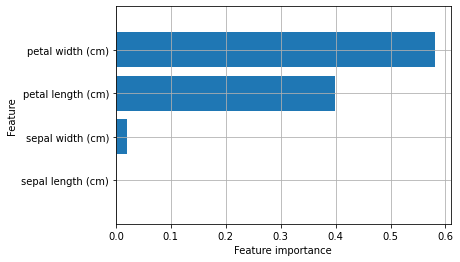

In [17]:
def plot_feature_importances_iris(model):
    n_features = iris.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), iris.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.grid()

plot_feature_importances_iris(clf)

## Random Forest

### Analyzing random forests

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=2)

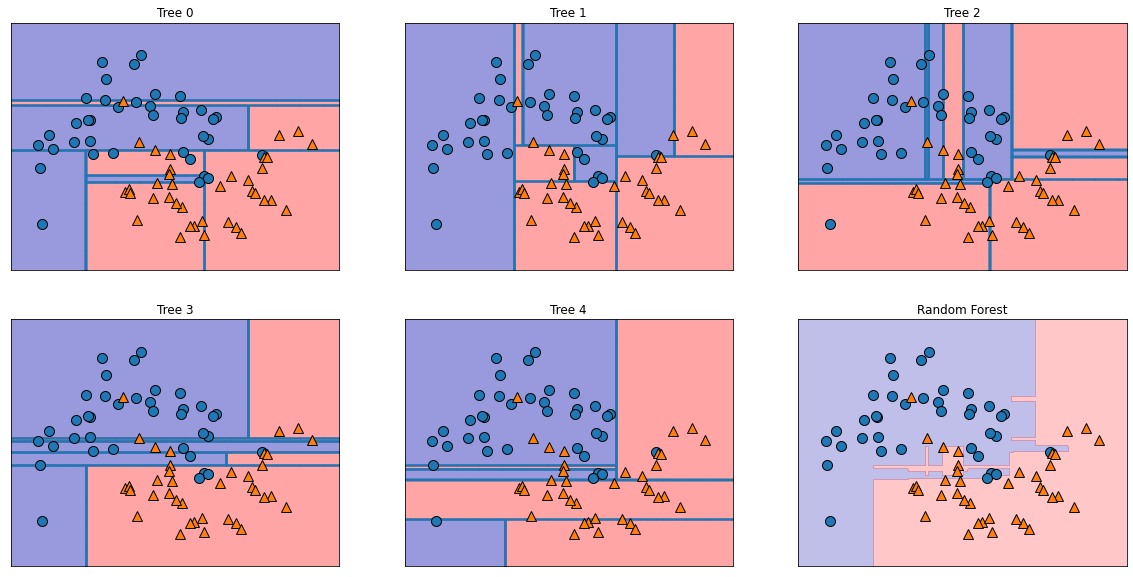

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    plot_tree_partition(X_train, y_train, tree, ax=ax)
    
plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1],
                                alpha=.25)
axes[-1, -1].set_title("Random Forest")
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.974


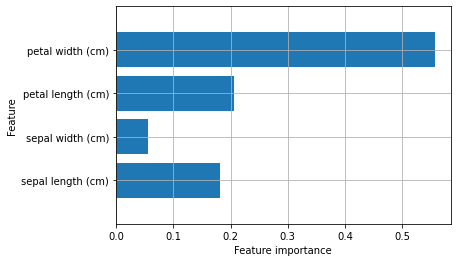

In [21]:
plot_feature_importances_iris(forest)

### Gradient Boosted Regression Trees (Gradient Boosting Machines)

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
#Default seeting:  learning_rate=0.1, n_estimators=100, subsample=1.0

X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.974


In [23]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1,  learning_rate=0.005)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.964
Accuracy on test set: 0.895


In [24]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=2, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.973
Accuracy on test set: 0.974


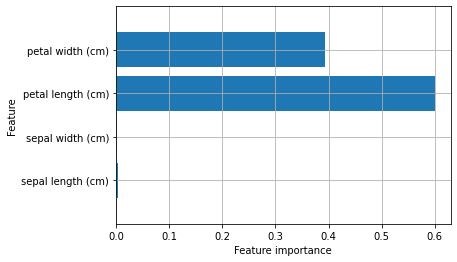

In [25]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_iris(gbrt)

## DT vs. RF vs. GBT for IRIS dataset
Plot the decision surfaces of forests of randomized trees trained on pairs of features of the iris dataset.

This plot compares the decision surfaces learned by a decision tree classifier (first column), by a random forest classifier (second column) and by gradient boosted tree classifier (third column).

In the first row, the classifiers are built using the sepal width and the sepal length features only, on the second row using the petal length and sepal length only, and on the third row using the petal width and the petal length only.

DecisionTree with features [0, 1] has a score of 0.9266666666666666
RandomForest with 5 estimators with features [0, 1] has a score of 0.9133333333333333
GradientBoosting with 5 estimators with features [0, 1] has a score of 0.8333333333333334

DecisionTree with features [0, 2] has a score of 0.9933333333333333
RandomForest with 5 estimators with features [0, 2] has a score of 0.9866666666666667
GradientBoosting with 5 estimators with features [0, 2] has a score of 0.98

DecisionTree with features [2, 3] has a score of 0.9933333333333333
RandomForest with 5 estimators with features [2, 3] has a score of 0.9933333333333333
GradientBoosting with 5 estimators with features [2, 3] has a score of 0.9933333333333333



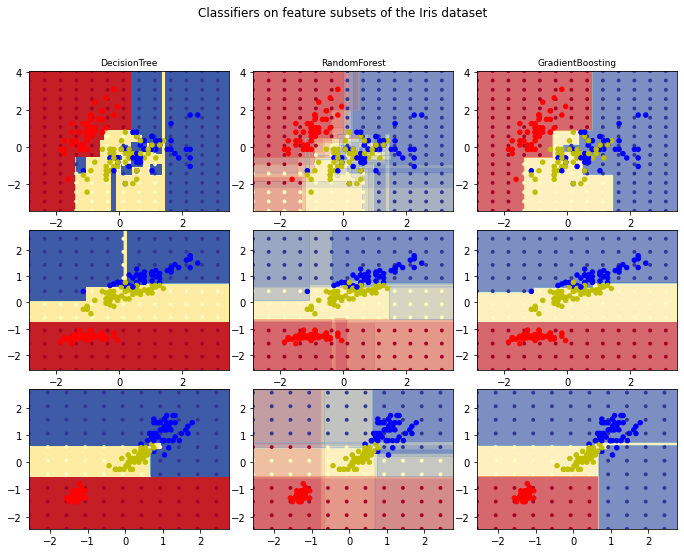

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 5
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None,random_state=0),
          RandomForestClassifier(n_estimators=n_estimators,random_state=0),
          GradientBoostingClassifier(n_estimators=n_estimators,random_state=0)]
plt.figure(figsize=(10,8))
for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        model.fit(X, y)

        scores = model.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(
            ".")[-1][:-2][:-len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(
                len(model.estimators_))
        print(model_details + " with features", pair,
              "has a score of", scores)

        plt.subplot(3, 3, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title, fontsize=9)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators that are in use (some algorithms can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for clf in model.estimators_:
                if model == models[-1]:
                    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
                else:                
                    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                         yy_coarser.ravel()]
                                         ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                                c=Z_points_coarser, cmap=cmap,
                                edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(X[:, 0], X[:, 1], c=y,
                    cmap=ListedColormap(['r', 'y', 'b']),
                     s=20)
        plot_idx += 1  # move on to the next plot in sequence
    print()

plt.suptitle("Classifiers on feature subsets of the Iris dataset", fontsize=12)
plt.axis("tight")
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.show()